# Applying GrandPrix on droplet based single-cell RNA-seq of mouse embryonic stem cells
_Sumon Ahmed_, 2017, 2018

This notebooks shows how GrandPrix with informative prior over the latent space can be used to infer one dimensional pseudotime from single cell RNA-seq generated using droplet barcoding. Models with both informative and non-informative priors are examined and compared with the diffusion pseudotime (DPT) framework.

Our model supports mixed precision computation. This notebook is an example of running the model with lower precision floating point. 

In [1]:
import pandas as pd
import numpy as np
from GrandPrix import GrandPrix

## Helper function

__MapTo01__ converts everything between [0,1]

In [2]:
def MapTo01(y):
    return (y.copy() - y.min(0)) / (y.max(0) - y.min(0))

## Data description

<a href="https://www.ncbi.nlm.nih.gov/pubmed/26000487" target="_blank">Klein et al. (2015)</a> developed a method termed inDrop (indexing droplet) based on droplet microfluidics and assayed the gene expression profiles and differentiation heterogeneity of mouse stem cells after leukemia inhibitory factor (LIF) withdrawal.

<a href="https://www.ncbi.nlm.nih.gov/m/pubmed/27571553/" target="_blank">Haghverdi et al. (2016)</a> have applied cell cycle normalization on this data and used it to infer diffusion pseudotime (DPT).

The __dropSeq.csv__ file contains cell cycle normalized expression profiles of __2717__ cells and __2047__ genes.

The __dropsecMeta.csv__ file contains the additional information of the data such as capture time of each cells, diffusion pseudotimes, etc.

In [4]:
Y = pd.read_csv('../data/dpt/dropSeq.csv', index_col=[0]).T
mData = pd.read_csv('../data/dpt/dropsecMeta.csv', index_col=[0])

In [5]:
N, D = Y.shape
print('Cells: %s, Genes: %s'%(N, D))

Cells: 2717, Genes: 2047


In [6]:
mData.head()

,capture.orig,dpt,pt_np_32,pt_np_32_trun,pt_np_64,pt_np_64_trun,pt_wp_32,pt_wp_32_trun
Cell-0,1,0.014755,0.106019,0.072093,0.196619,0.133701,0.154985,0.105390
Cell-1,1,0.010067,0.106081,0.072135,0.274731,0.186817,0.106716,0.072567
Cell-2,1,0.009285,0.199391,0.135586,0.185167,0.125913,0.109926,0.074750
Cell-3,1,0.042065,0.222770,0.151484,0.303305,0.206247,0.156400,0.106352
Cell-4,1,0.021697,0.187327,0.127382,0.267089,0.181621,0.135322,0.092019


## Actual capture time and diffusion pseudotime

In [7]:
dpt = mData['dpt'].values
cpt = mData['capture.orig'].values

## Model with Informative prior

Capture time points have been used as the informative prior information over pseudotime. Following arguments have been passed to initialize the model.

<!--
-  __data__: _array-like, shape N x D_. Observed data, where N is the number of time points and D is the number of genes.
-  __latent_prior_mean__: _array-like, shape N_ x 1, _optional (default:_ __0__). > Mean of the prior distribution over pseudotime.
-  __latent_prior_var__: _array-like, shape N_ x 1, _optional (default:_ __1.__). Variance of the prior distribution over pseudotime.
-  __latent_mean__: _array-like, shape N_ x 1, _optional (default:_ __1.__). Initial mean values of the approximate posterior distribution over pseudotime.
-  __latent_var__: _array-like, shape N_ x 1, _optional (default:_ __1.__). Initial variance of the approximate posterior distribution over pseudotime.
- __kernel:__ _optional (default: RBF kernel with lengthscale and variance set to 1.0)_. Covariance function to define the mapping from the latent space to the data space in Gaussian process prior. 

-->

-  __data__: _array-like, shape N x D_. Observed data, where N is the number of time points and D is the number of genes.


-  __n_inducing_points__: _int_. Number of inducing points.


-  __latent_prior_mean__: _array-like, shape N_ x 1. Mean of the prior distribution over pseudotime.


-  __latent_prior_var__: _array-like, shape N_ x 1. Variance of the prior distribution over pseudotime.


-  __latent_mean__: _array-like, shape N_ x 1. Initial mean values of the approximate posterior distribution over pseudotime.

In [9]:
M = 60 #number of inducing points
sigma_t = 1.
prior_mean = MapTo01(mData['capture.orig'].values[:, None])
np.random.seed(10)
X_mean = np.zeros((N, 1)) # initialize latent_mean
for i in range(0, N):
    X_mean[i, 0] = prior_mean[i, 0] + 1.2 * np.random.randn(1)

In [10]:
pt_wp, var_wp = GrandPrix.fit_model(data=Y.values, n_inducing_points=M, latent_prior_mean=prior_mean,
                latent_prior_var=np.square(sigma_t), latent_mean=X_mean)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 13321109.078719
  Number of iterations: 34
  Number of functions evaluations: 39


## Model without using Informative prior

In [22]:
np.random.seed(10)
pt_np, var_np = GrandPrix.fit_model(data=Y.values, n_inducing_points=M)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 12742035.846280
  Number of iterations: 146
  Number of functions evaluations: 161


## Spearman correlation

In [23]:
from scipy.stats import spearmanr
from beautifultable import BeautifulTable
table = BeautifulTable()

table.column_headers = ["", "No Prior", "With Prior"]
table.append_row(["Capture time", "%f"%(spearmanr(pt_np, cpt)[0]), "%f"%(spearmanr(pt_wp, cpt)[0])])
table.append_row(["Diffusion Pseudotime", "%s"%(spearmanr(pt_np, dpt)[0]), "%f"%(spearmanr(pt_wp, dpt)[0])])

table.left_padding_widths['No Prior'] = 10
table.right_padding_widths['With Prior'] = 10

print("Spearman Correlation between the estimated pseudotime with known values: \n")
print(table)

Spearman Correlation between the estimated pseudotime with known values: 

+----------------------+-------------------+---------------------+
|                      |          No Prior | With Prior          |
+----------------------+-------------------+---------------------+
|     Capture time     |           -0.917  |   0.912             |
+----------------------+-------------------+---------------------+
| Diffusion Pseudotime |           -0.938  |   0.953             |
+----------------------+-------------------+---------------------+


## Pearson correlation

In [24]:
from scipy.stats import pearsonr
table = BeautifulTable()

table.column_headers = ["", "No Prior", "With Prior"]
table.append_row(["Diffusion Pseudotime", "%s"%(pearsonr(pt_np.reshape(-1), dpt.reshape(-1))[0]),
                  "%f"%(pearsonr(pt_wp.reshape(-1), dpt.reshape(-1))[0])])

table.left_padding_widths['No Prior'] = 10
table.right_padding_widths['With Prior'] = 10

print("Linear Correlation between the estimated pseudotime with known values: \n")
print(table)

Linear Correlation between the estimated pseudotime with known values: 

+----------------------+-------------------+---------------------+
|                      |          No Prior | With Prior          |
+----------------------+-------------------+---------------------+
| Diffusion Pseudotime |           -0.92   |   0.964             |
+----------------------+-------------------+---------------------+


/home/sumon/anaconda3/envs/tensor_15/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-04-30 14:26:44.931797. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


# Visualize the results
The informative prior on capture time helps the model to infer pseudotime having similar pseudotime density to DPT.

/home/sumon/anaconda3/envs/tensor_15/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-04-30 14:26:46.501067. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


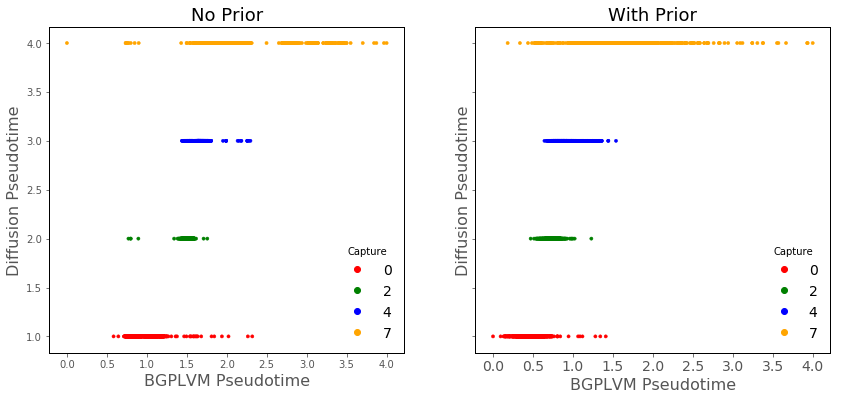

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt
from utils import correlation_dpt
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
correlation_dpt(MapTo01(-pt_np)*max(cpt), cpt, mData['capture.orig'].values, ax[0], 'No Prior')
correlation_dpt(MapTo01(pt_wp)*max(cpt), cpt, mData['capture.orig'].values, ax[1], 'With Prior')

/home/sumon/anaconda3/envs/tensor_15/lib/python3.5/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-04-30 14:26:47.595491. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


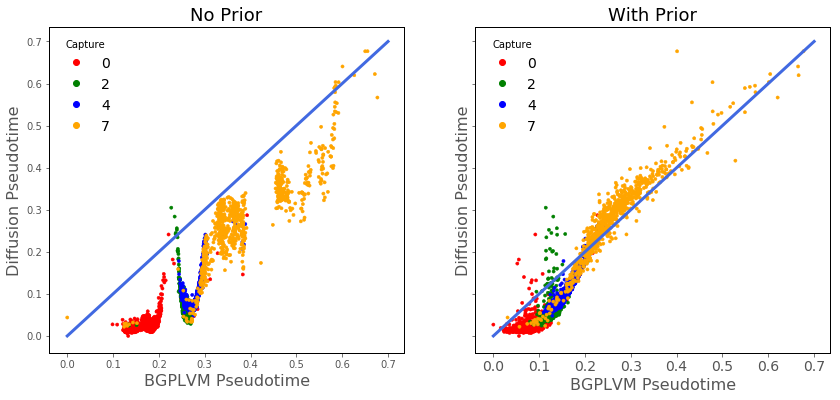

In [26]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
correlation_dpt(MapTo01(-pt_np)*max(dpt), dpt, mData['capture.orig'].values, ax[0], 'No Prior', diagLine=True)
correlation_dpt(MapTo01(pt_wp)*max(dpt), dpt, mData['capture.orig'].values, ax[1], 'With Prior', diagLine=True)